## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
import theano as th
import theano.tensor as T
from keras import backend as kBack
kBack.set_image_dim_ordering('th')
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
Using Theano backend.


# Dataset setup

In [2]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [3]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [4]:
in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods

(110000, 2, 128) [2, 128]


# Build the NN Model

In [5]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

/opt/conda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), kernel_initializer="glorot_uniform", name="conv1", activation="relu", padding="valid")`
  if sys.path[0] == '':
/opt/conda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), kernel_initializer="glorot_uniform", name="conv2", activation="relu", padding="valid")`
  from ipykernel import kernelapp as app
/opt/conda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1")`
/opt/conda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, kernel_initializer="he_normal", name="dense2")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 1, 132)        0         
__________

In [6]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

/opt/conda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 110000 samples, validate on 110000 samples
Epoch 1/100
 - 1381s - loss: 2.2610 - val_loss: 2.1323
Epoch 2/100
 - 1374s - loss: 2.0503 - val_loss: 1.9182
Epoch 3/100
 - 1382s - loss: 1.8842 - val_loss: 1.7776
Epoch 4/100
 - 1385s - loss: 1.7942 - val_loss: 1.7049
Epoch 5/100
 - 1387s - loss: 1.7196 - val_loss: 1.6158
Epoch 6/100
 - 1393s - loss: 1.6389 - val_loss: 1.5346
Epoch 7/100
 - 1429s - loss: 1.5805 - val_loss: 1.4761
Epoch 8/100
 - 1449s - loss: 1.5441 - val_loss: 1.4359
Epoch 9/100
 - 3183s - loss: 1.5148 - val_loss: 1.4131
Epoch 10/100


# Evaluate and Plot Model Performance

In [10]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print score

1.28160194596


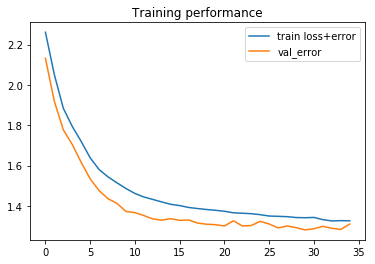

In [11]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

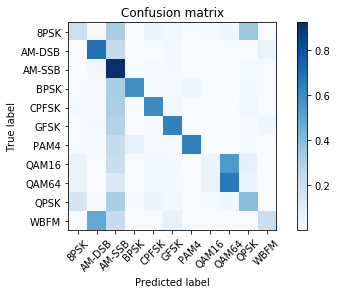

In [13]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.0975297346752
Overall Accuracy:  0.0910081743869
Overall Accuracy:  0.0958755426918
Overall Accuracy:  0.108264164562
Overall Accuracy:  0.140565177758
Overall Accuracy:  0.224986671406
Overall Accuracy:  0.319125482271
Overall Accuracy:  0.492302052786
Overall Accuracy:  0.615157116451
Overall Accuracy:  0.677068214804
Overall Accuracy:  0.710401459854
Overall Accuracy:  0.70756088695
Overall Accuracy:  0.733113069016
Overall Accuracy:  0.731407942238
Overall Accuracy:  0.730207394049
Overall Accuracy:  0.737887067395
Overall Accuracy:  0.718812239725
Overall Accuracy:  0.731315740912
Overall Accuracy:  0.725610859729
Overall Accuracy:  0.725112511251


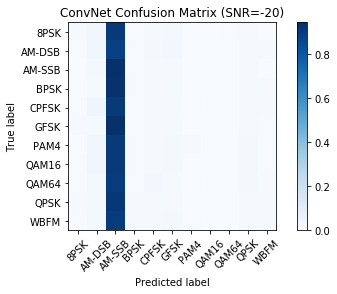

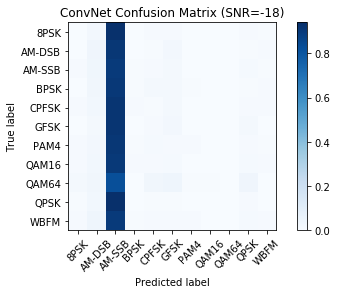

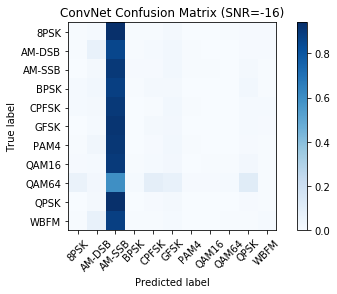

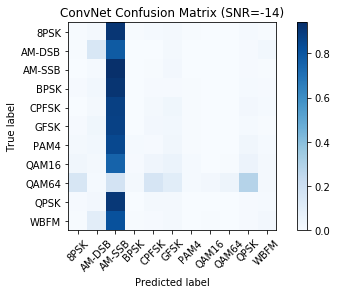

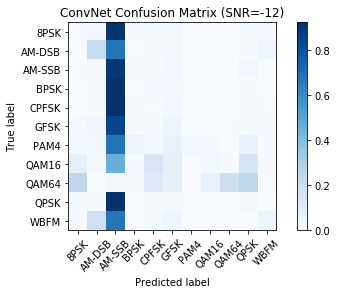

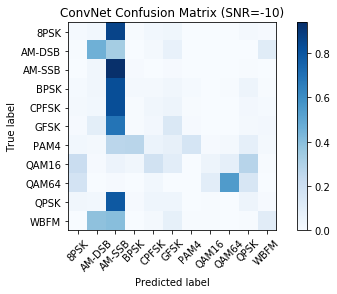

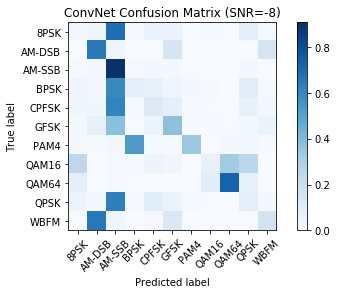

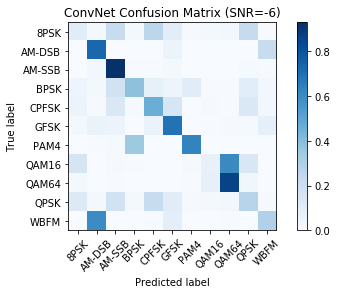

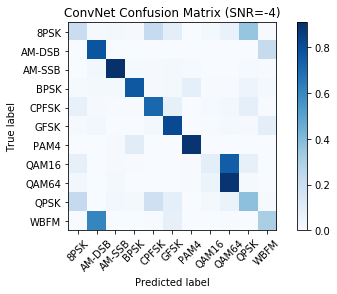

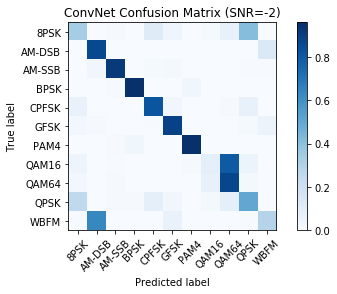

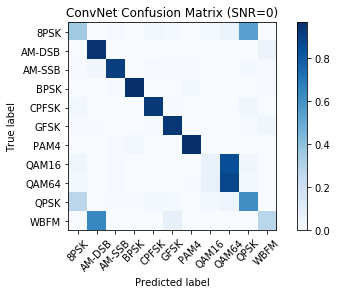

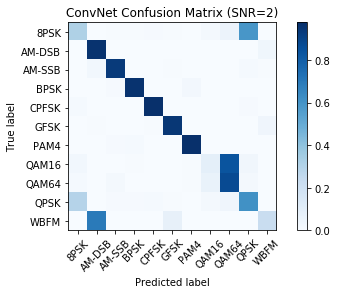

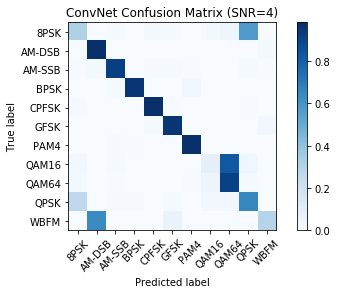

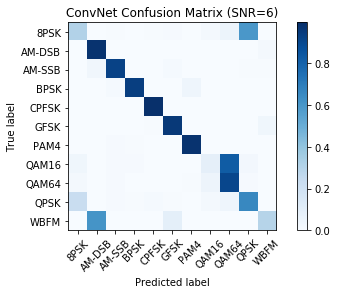

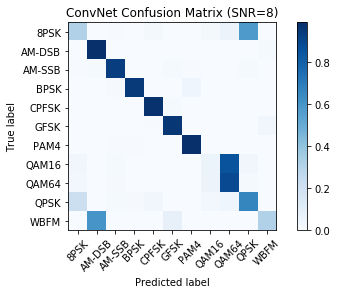

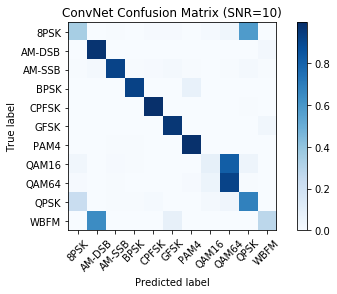

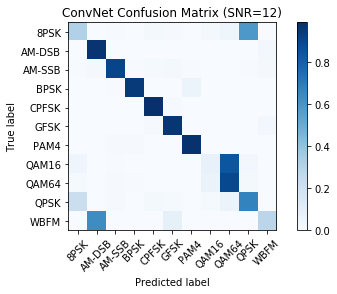

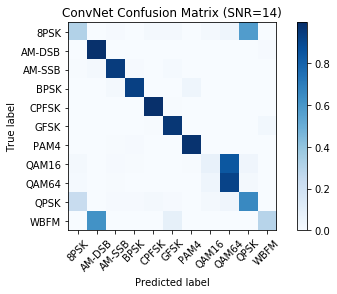

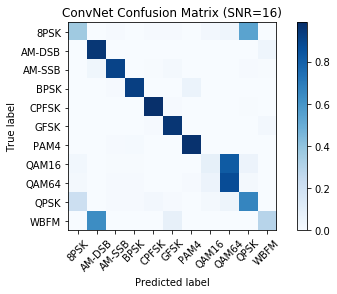

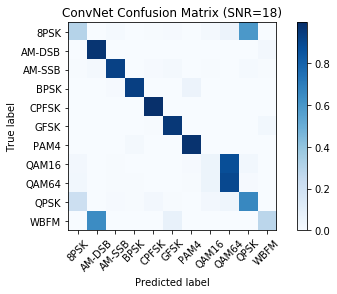

In [14]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [16]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.71040145985401459, 16: 0.72561085972850681, 2: 0.70756088695019992, 4: 0.7331130690161527, 6: 0.73140794223826711, 8: 0.7302073940486925, 12: 0.71881223972478725, 10: 0.73788706739526411, -20: 0.097529734675205856, 18: 0.72511251125112508, -18: 0.091008174386920979, -16: 0.095875542691751081, -14: 0.10826416456153014, -12: 0.1405651777575205, 14: 0.73131574091160734, -10: 0.2249866714057224, -8: 0.31912548227080656, -6: 0.49230205278592376, -4: 0.61515711645101667, -2: 0.67706821480406387}


Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

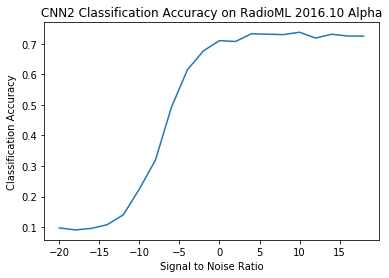

In [15]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")